In [1]:
# Workaround to ensure lazy evaluation of xhistorams
# see https://github.com/xgcm/xhistogram/issues/12

import os
os.environ["NUMPY_EXPERIMENTAL_ARRAY_FUNCTION"] = "0"

In [2]:
# parameters
dataset_version = "v2019.09.11.2"
bucket_stokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_with_stokes.zarr"
bucket_nostokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_without_stokes.zarr"

filter_warnings = "ignore"  # No warnings will bother you.  Change for debugging.

## Load all modules and spin up a Dask cluster

In [3]:
%matplotlib inline
from dask import array as da
import numpy as np
import xarray as xr
from gcsfs.mapping import GCSMap
from xhistogram.xarray import histogram as xhist
from matplotlib import pyplot as plt
import pandas as pd
from dask import delayed

In [4]:
import warnings
warnings.filterwarnings(filter_warnings)

In [5]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
cluster.adapt(minimum=8, maximum=60, wait_count=15)

client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.5:38561 Dashboard: /user/0000-0003-1951-8494/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
import cloudpickle

In [7]:
with open("intermediate_data/all_traj_dataframe.pickle", mode="rb") as f:
    data = cloudpickle.load(f)

In [8]:
data

data  \
stokes MPA k                                                       
True   1    0  [MPA, distance, land, lat, lon, temp, time, be...   
       2    0  [MPA, distance, land, lat, lon, temp, time, be...   
       3    0  [MPA, distance, land, lat, lon, temp, time, be...   
       4    0  [MPA, distance, land, lat, lon, temp, time, be...   
       5    0  [MPA, distance, land, lat, lon, temp, time, be...   
       6    0  [MPA, distance, land, lat, lon, temp, time, be...   
       7    0  [MPA, distance, land, lat, lon, temp, time, be...   
       8    0  [MPA, distance, land, lat, lon, temp, time, be...   
       9    0  [MPA, distance, land, lat, lon, temp, time, be...   
False  1    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       2    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       3    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       4    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       5    0  [MPA, distance, land, lat, lon, temp, time, be...   
...                                                          ...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       6    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       7    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       8    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       9    0  [MPA, distance, land, lat, lon, temp, time, be...   
            1  [MPA, distance, land, lat, lon, temp, time, be...   
            2  [MPA, distance, land, lat, lon, temp, time, be...   
            3  [MPA, distance, land, lat, lon, temp, time, be...   
            4  [MPA, distance, land, lat, lon, temp, time, be...   
       1   -1  [MPA, distance, land, lat, lon, temp, time, be...   
       2   -1  [MPA, distance, land, lat, lon, temp, time, be...   
       3   -1  [MPA, distance, land, lat, lon, temp, time, be...   
       4   -1  [MPA, distance, land, lat, lon, temp, time, be...   
       5   -1  [MPA, distance, land, lat, lon, temp, time, be...   
       6   -1  [MPA, distance, land, lat, lon, t

(9, 3)


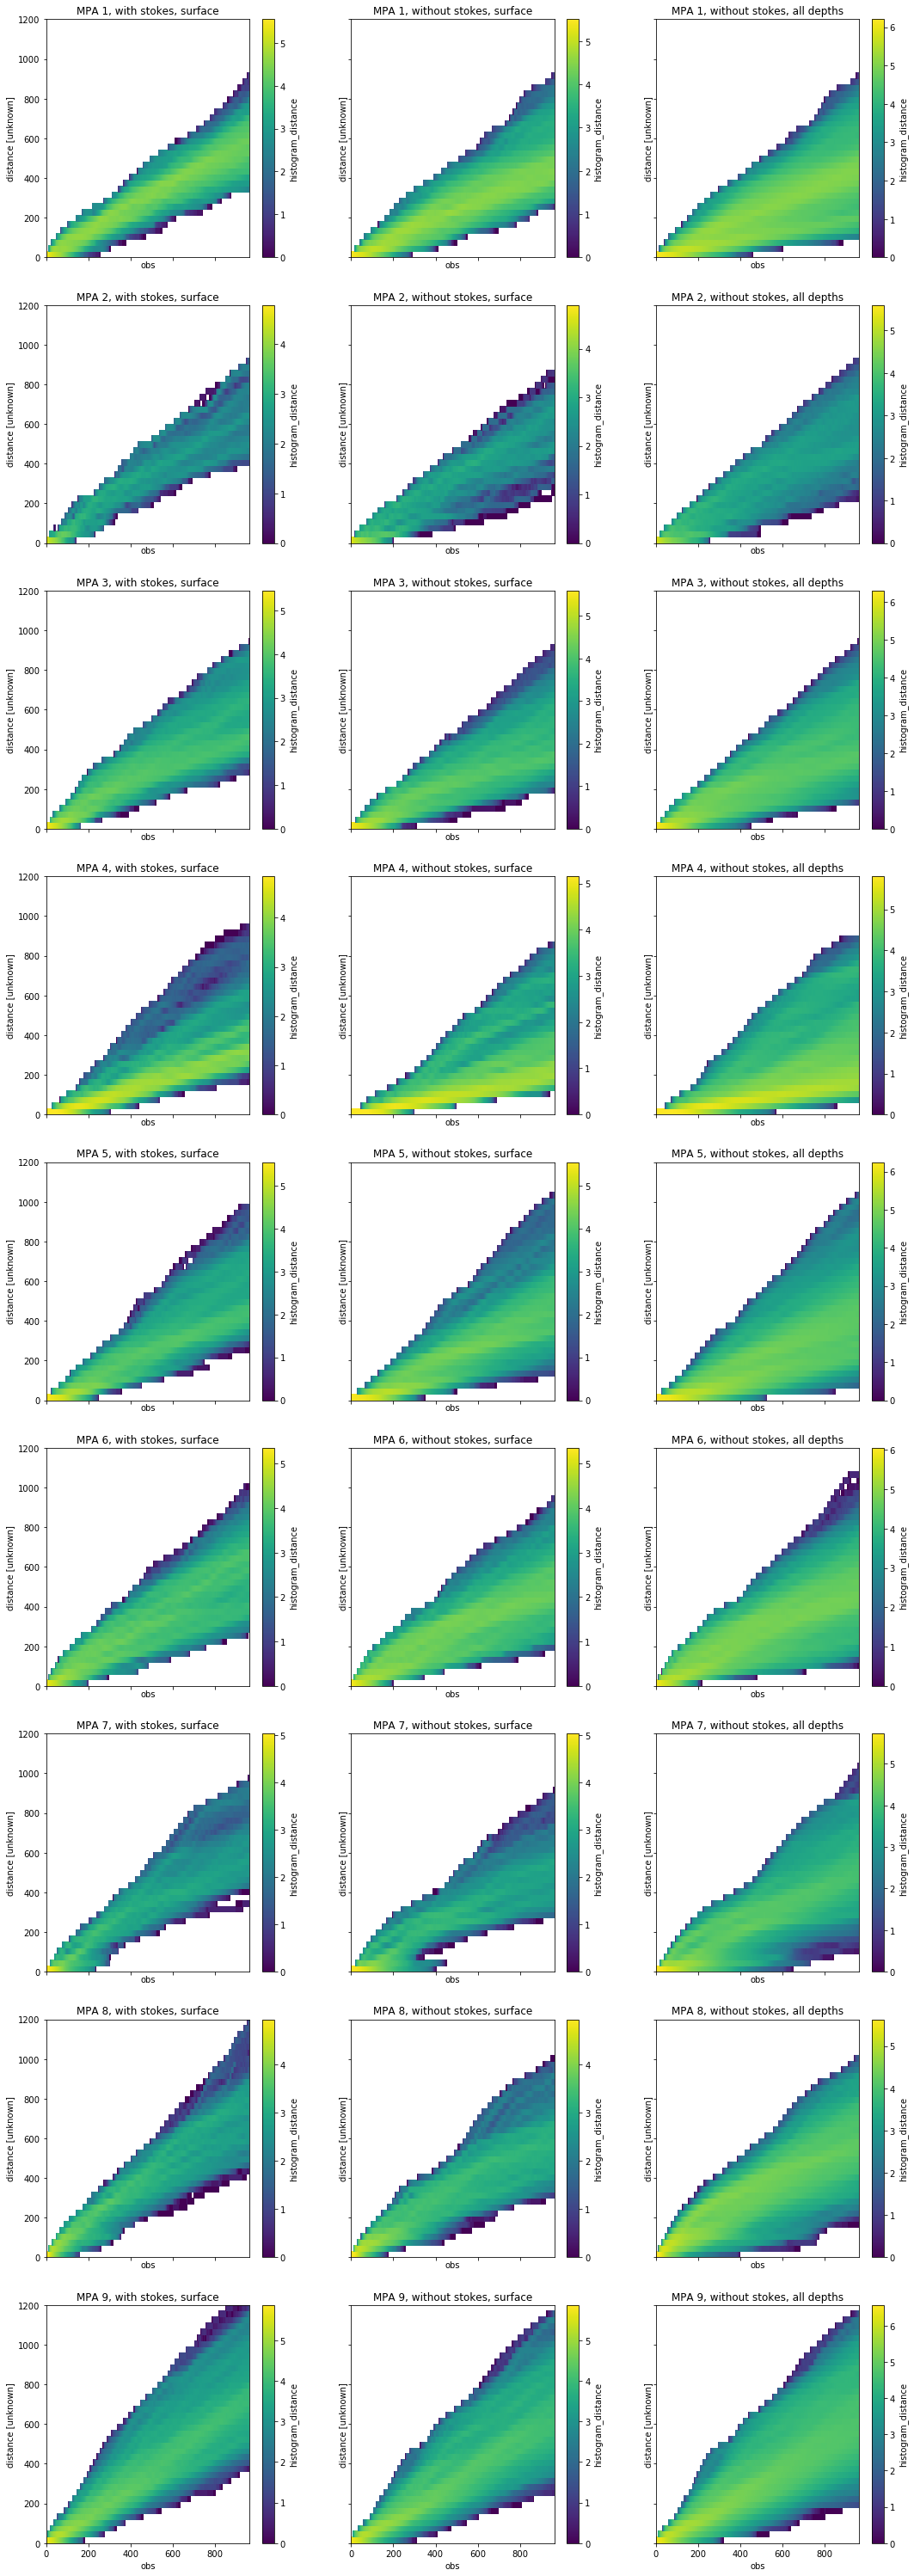

In [9]:
fig, ax = plt.subplots(9, 3, sharex=True, sharey=True, figsize=(18, 54))
print(ax.shape)

for MPA in range(1, 10):
    
    xr.ufuncs.log10(
        xhist(
            data.loc[True, MPA, 0]["data"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 0], x="obs", y="distance_bin")
    
    ax[MPA-1, 0].set_title(f"MPA {MPA}, with stokes, surface")
    
    xr.ufuncs.log10(
        xhist(
            data.loc[False, MPA, 0]["data"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 1], x="obs", y="distance_bin")
    
    ax[MPA-1, 1].set_title(f"MPA {MPA}, without stokes, surface")
    
    xr.ufuncs.log10(
        xhist(
            data.loc[False, MPA, -1]["data"].distance.persist(retries=40),
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]).compute(retries=40)
    ).plot(ax=ax[MPA-1, 2], x="obs", y="distance_bin")
    
    ax[MPA-1, 2].set_title(f"MPA {MPA}, without stokes, all depths")

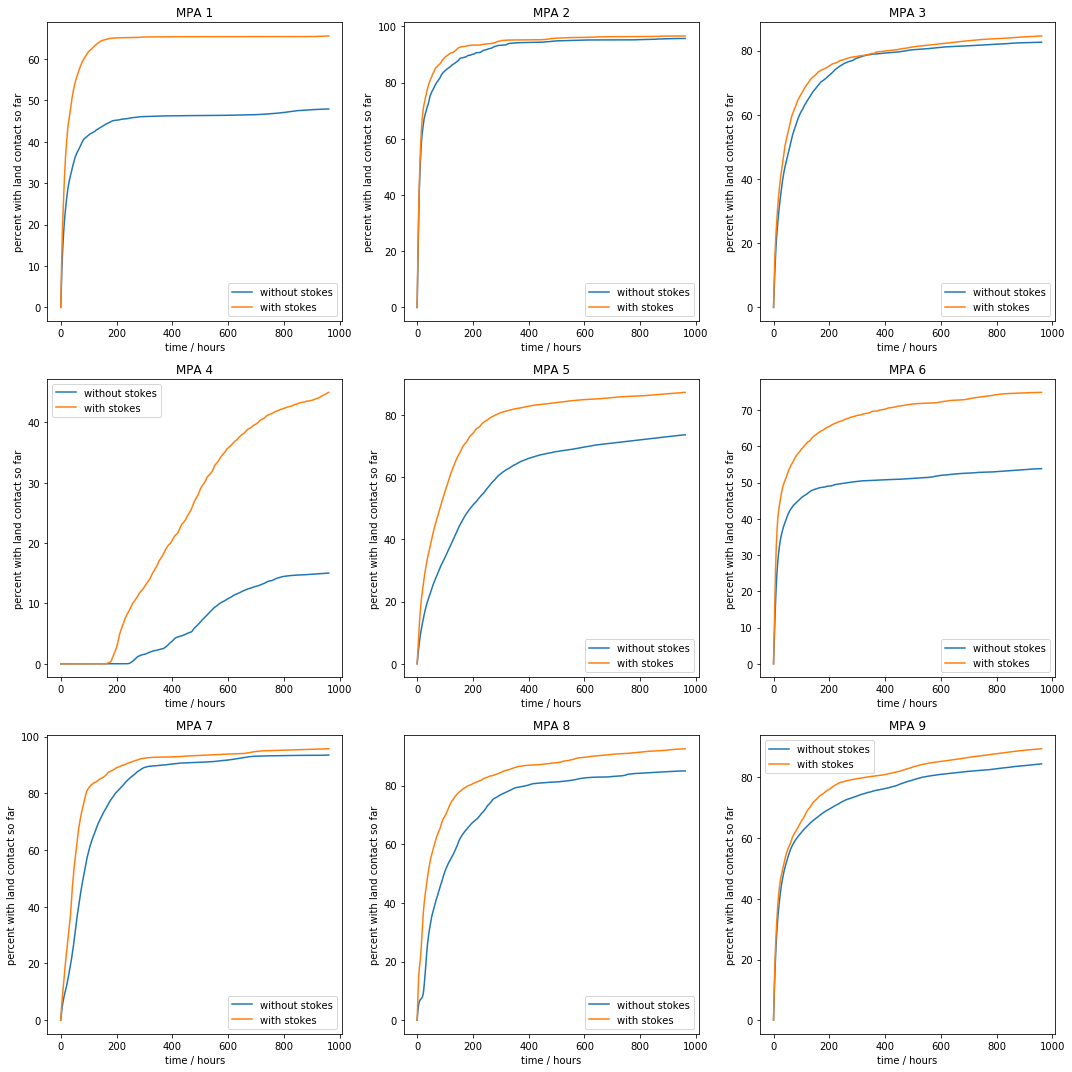

In [10]:
fig, ax = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(15, 15))
ax = ax.flatten()

for MPA in range(1, 10):
    (data.loc[False, MPA, 0]["data"].distance.isnull().mean("traj") * 100).compute(retries=40).plot(ax=ax[MPA-1], label="without stokes");
    (data.loc[True, MPA, 0]["data"].distance.isnull().mean("traj") * 100).compute(retries=40).plot(ax=ax[MPA-1], label="with stokes");
    
    ax[MPA-1].set_title(f"MPA {MPA}")
    ax[MPA-1].set_xlabel("time / hours")
    ax[MPA-1].set_ylabel("percent with land contact so far")
    ax[MPA-1].legend(loc=0, ncol=1);

fig.tight_layout();

In [36]:
hist_stokes = xr.concat(
    map(
        lambda MPA: xhist(
            data.loc[True, MPA, 0]["data"].isel(obs=-1).distance,
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]
        ),
        range(1, 10)
    ), dim="MPA")

In [37]:
hist_nostokes = xr.concat(
    map(
        lambda MPA: xhist(
            data.loc[False, MPA, 0]["data"].isel(obs=-1).distance,
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", ]
        ),
        range(1, 10)
    ), dim="MPA")

In [55]:
hist_nostokes_alldepths = xr.concat(
    map(
        lambda MPA: xhist(
            data.loc[False, MPA, -1]["data"].sel(obs=slice(35 * 24, None)).distance,
            bins=[np.linspace(0, 1200, 41), ],
            dim=["traj", "obs"]
        ),
        range(1, 10)
    ), dim="MPA")

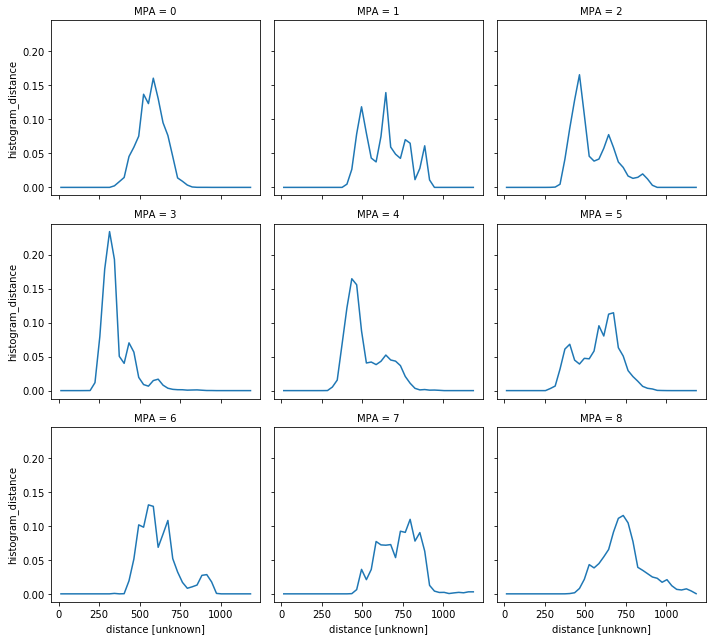

In [46]:
(hist_stokes / hist_stokes.sum("distance_bin")).compute(retries=40).plot(x="distance_bin", col="MPA", col_wrap=3);

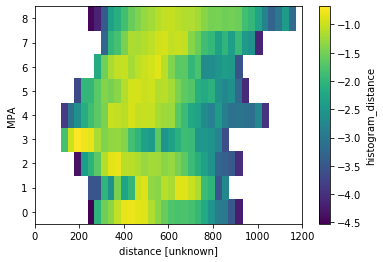

In [53]:
xr.ufuncs.log10(hist_nostokes / hist_nostokes.sum("distance_bin")).compute(retries=40).plot();

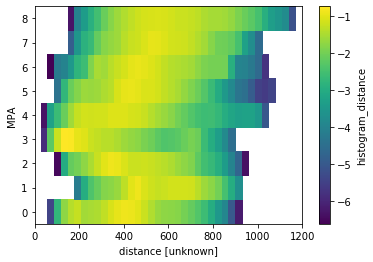

In [56]:
xr.ufuncs.log10(hist_nostokes_alldepths / hist_nostokes_alldepths.sum("distance_bin")).compute(retries=40).plot();